# Case Study A-Z: A Machine Learning powered Strategy (DNN)

_Disclaimer: <br>
The following illustrative example is for general information and educational purposes only. <br>
It is neither investment advice nor a recommendation to trade, invest or take whatsoever actions.<br>
The below code should only be used in combination with an Oanda/FXCM Practice/Demo Account and NOT with a Live Trading Account._

## Getting and Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import yfinance as yf
import pandas_ta as ta
#pip install zigzag
from zigzag import *

# Preprocessing data
from talib import abstract
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import math # Mathematical functions 


/tmp/ipykernel_6749/313883057.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


[*********************100%***********************]  1 of 1 completed
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0


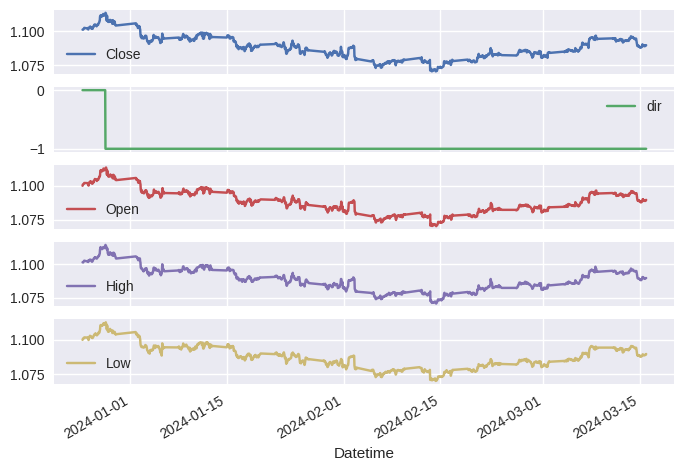

In [2]:
#data = pd.read_csv("DNN_data.csv", parse_dates = ["time"], index_col = "time")
# Data download
symbol = "EURUSD=X"
period ='60d'
interval ='1h'

# load data
def get_yfinance_hist(symbol = "EURUSD=X", period ='1mo', interval ='15m', show_plot = True ):
    df_raw = yf.download(symbol,period= period ,interval=interval)
    df_raw["returns"] = np.log(df_raw.Close.div(df_raw.Close.shift(1)))
    df_raw.dropna(how="any",inplace=True)
    df_raw = df_raw.drop('Volume', axis=1)

    #Convert data into numpy array
    closing_prices = np.asarray(df_raw['Close'])

    #Calculate min/max points
    min_max_points = peak_valley_pivots(closing_prices, 0.008,-0.008)

    #Add as a column to the original df2
    df_raw['Min/Max Points'] = min_max_points

    #Replace all 0s with NaN values
    df_raw['Min/Max Points'] = df_raw['Min/Max Points'].replace(0,np.NaN)#Interpolate

    df_raw['dir'] = 0
    lastValue = 0
    df_raw['Min/Max Points'].fillna(0, inplace=True)
    for i, row in df_raw.iterrows():
        if row['Min/Max Points'] != 0:
            print(row['Min/Max Points'])
            
            if(row['Min/Max Points'] == -1):
              lastValue = 1
        
            if(row['Min/Max Points'] == 1):
              lastValue = 0
        
        df_raw.at[i,'dir'] = lastValue


    if(show_plot):
      plot_cols = ['Close', 'dir', 'Open', 'High', 'Low']
      plot_features = df_raw[plot_cols]
      plot_features.index = df_raw.index
      _ = plot_features.plot(subplots=True)

    df_raw = df_raw.dropna()

    return df_raw

data = get_yfinance_hist(symbol = symbol, period = period, interval= interval )


In [3]:
def add_signal_indicators(df):
    df['SMA_10'] = ta.sma(df['Adj Close'],length=10)
    df['SMA_30'] = ta.sma(df['Adj Close'],length=30)
    df['SMA_50'] = ta.sma(df['Adj Close'],length=50)
    df['SMA_200'] = ta.sma(df['Adj Close'],length=200)
    
    macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_hist'] = macd['MACDh_12_26_9']

    df['10_cross_30'] = np.where(df['SMA_10'] > df['SMA_30'], 1, 0)
    
    df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] < df['MACD'], 1, 0)
    
    df['MACD_lim'] = np.where(df['MACD']>0, 1, 0)
    
    df['abv_50'] = np.where((df['SMA_30']>df['SMA_50'])
                            &(df['SMA_10']>df['SMA_50']), 1, 0)
                            
    df['abv_200'] = np.where((df['SMA_30']>df['SMA_200'])
                            &(df['SMA_10']>df['SMA_200'])
                            &(df['SMA_50']>df['SMA_200']), 1, 0)
    
    return df

#data = add_signal_indicators(data)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1399 entries, 2023-12-25 01:00:00+00:00 to 2024-03-15 22:00:00+00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1399 non-null   float64
 1   High            1399 non-null   float64
 2   Low             1399 non-null   float64
 3   Close           1399 non-null   float64
 4   Adj Close       1399 non-null   float64
 5   returns         1399 non-null   float64
 6   Min/Max Points  1399 non-null   float64
 7   dir             1399 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 98.4 KB


In [5]:
#data["returns"] = data[symbol] / data[symbol].shift()
data["returns"] = np.log(data['Close'] / data['Close'].shift())

## Adding Label/Features

In [6]:
window = 50

In [7]:
df = data.copy()
df.dropna(inplace = True)

In [8]:
df.head()

,Open,High,Low,Close,Adj Close,returns,Min/Max Points,dir
Datetime,,,,,,,,
2023-12-25 02:00:00+00:00,1.10084,1.10120,1.10059,1.10096,1.10096,0.00000,0.00000,0
2023-12-25 03:00:00+00:00,1.10096,1.10132,1.10072,1.10096,1.10096,0.00000,0.00000,0
2023-12-25 04:00:00+00:00,1.10108,1.10120,1.10059,1.10120,1.10120,0.00022,0.00000,0
2023-12-25 05:00:00+00:00,1.10120,1.10181,1.10108,1.10156,1.10156,0.00033,0.00000,0
2023-12-25 06:00:00+00:00,1.10156,1.10205,1.10120,1.10181,1.10181,0.00022,0.00000,0


## Adding Features

In [9]:
lags = 5

In [10]:
cols = []
features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]

In [11]:

for lag in range(1, lags + 1):
    col = "lag{}".format(lag)
    df[col] = df["returns"].shift(lag)
    cols.append(col)
          
df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
cols.append('Ask_Dir')

df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
cols.append('SMA')
df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
cols.append('SMA_Dir')

df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
cols.append('RSI')
df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
cols.append('RSI_Dir')

df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
cols.append('fastk')
cols.append('fastd')
df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
cols.append('fastk_Dir')
df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)    
cols.append('fastd_Dir')            
   
            
df.dropna(inplace = True)

## Splitting into Train and Test Set

In [12]:
len(df)

1378

In [13]:
split = int(len(df)*0.66)
split

909

In [14]:
train = df.iloc[:split].copy()

In [15]:
test = df.iloc[split:].copy()

## Feature Scaling (Standardization)

In [16]:
mu, std = train.mean(), train.std() # train set parameters (mu, std) for standardization

In [17]:
train_s = (train - mu) / std # standardization of train set features

## Creating and Fitting the DNN Model

In [18]:
from DNNModel import *


2024-03-17 08:35:29.621730: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 08:35:29.924860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 08:35:29.928126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 08:35:35.108184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
# fitting a DNN model with 3 Hidden Layers (50 nodes each) and dropout regularization

set_seeds(100)
model = create_model(hl = 3, hu = 50, dropout = True, input_dim = len(cols))
model.fit(x = train[cols], y = train["dir"], epochs = 50, verbose = False,
          validation_split = 0.2, shuffle = False, class_weight = cw(train))

ValueError: 'list' argument must have no negative elements

In [ ]:
model.evaluate(train_s[cols], train["dir"]) # evaluate the fit on the train set

 1/26 [>.............................] - ETA: 3s - loss: 0.2138 - accuracy: 0.9375

26/26 [==============================] - 0s 8ms/step - loss: 0.2522 - accuracy: 0.9001


[0.25220003724098206, 0.9001232981681824]

In [ ]:
pred = model.predict(train_s[cols]) # prediction (probabilities)
pred

26/26 [==============================] - 1s 8ms/step


array([[7.60065973e-01],
       [9.42768276e-01],
       [9.96748447e-01],
       [9.76524353e-01],
       [5.16979536e-03],
       [1.81309115e-02],
       [8.61899674e-01],
       [2.48779953e-02],
       [4.17308420e-01],
       [9.56711233e-01],
       [6.03648961e-01],
       [1.25522120e-02],
       [2.28879377e-02],
       [4.80855070e-02],
       [7.72482753e-01],
       [3.62039097e-02],
       [9.16439772e-01],
       [2.31903240e-01],
       [9.77077425e-01],
       [4.74969506e-01],
       [1.32927909e-01],
       [7.34898075e-03],
       [9.78337675e-02],
       [6.27178311e-01],
       [9.42811090e-03],
       [4.78561282e-01],
       [1.02223177e-02],
       [8.13440382e-01],
       [4.31619883e-01],
       [6.18358433e-01],
       [8.55636895e-01],
       [9.44486141e-01],
       [9.98997569e-01],
       [8.09245944e-01],
       [1.32843852e-03],
       [2.18731053e-02],
       [5.17906308e-01],
       [1.63879991e-02],
       [6.28747419e-02],
       [8.49342823e-01],


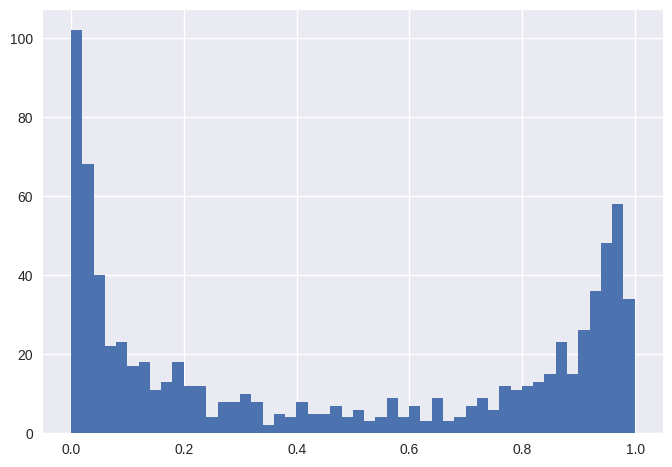

In [ ]:
plt.hist(pred, bins = 50)
plt.show()

## Out-Sample Prediction and Forward Testing

In [ ]:
test

,Open,High,Low,Close,Adj Close,returns,Min/Max Points,target,dir,sma,...,lag5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-21 09:00:00+00:00,1.08003,1.08026,1.07945,1.08026,1.08026,-0.00119,0.00000,1,0,0.00300,...,0.00011,1,-0.00010,1,39.99035,1,0.00000,20.07436,1,1
2024-02-21 10:00:00+00:00,1.08015,1.08061,1.07991,1.08038,1.08038,0.00011,0.00000,1,1,0.00301,...,-0.00032,0,-0.00006,0,51.28716,0,100.00000,52.33480,0,1
2024-02-21 11:00:00+00:00,1.08026,1.08050,1.07980,1.08015,1.08015,0.00011,0.00000,1,1,0.00303,...,0.00011,0,-0.00007,1,51.28706,0,99.99916,66.66639,0,1
2024-02-21 12:00:00+00:00,1.08026,1.08061,1.08003,1.08061,1.08061,0.00000,0.00000,1,0,0.00306,...,-0.00032,1,-0.00006,1,50.34738,1,91.71121,97.23679,1,0
2024-02-21 13:00:00+00:00,1.08061,1.08143,1.08061,1.08131,1.08131,0.00032,0.00000,1,1,0.00309,...,-0.00011,1,-0.00005,1,53.15569,1,100.00000,97.23679,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 18:00:00+00:00,1.08873,1.08932,1.08873,1.08932,1.08932,-0.00011,0.00000,-1,0,-0.00152,...,-0.00044,1,0.00006,1,49.33662,1,30.62001,46.98528,1,1
2024-03-15 19:00:00+00:00,1.08932,1.08944,1.08909,1.08921,1.08921,0.00054,0.00000,-1,1,-0.00163,...,-0.00022,0,0.00008,0,55.64712,0,100.00000,63.00619,0,0
2024-03-15 20:00:00+00:00,1.08921,1.08932,1.08897,1.08921,1.08921,-0.00011,0.00000,-1,0,-0.00176,...,0.00011,0,0.00006,0,48.98972,0,0.00000,43.54000,0,0


In [ ]:
test_s = (test - mu) / std # standardization of test set features (with train set parameters!!!)

In [ ]:
model.evaluate(test_s[cols], test["dir"])

14/14 [==============================] - 0s 9ms/step - loss: 0.2957 - accuracy: 0.8592


[0.2957007586956024, 0.8591885566711426]

In [ ]:
pred = model.predict(test_s[cols])
pred

14/14 [==============================] - 0s 6ms/step


array([[5.52331097e-03],
       [9.49733973e-01],
       [9.53968942e-01],
       [7.32681096e-01],
       [9.57409382e-01],
       [9.68429089e-01],
       [6.26040459e-01],
       [1.35709746e-02],
       [9.43442464e-01],
       [1.61584504e-02],
       [1.39693722e-01],
       [9.31355119e-01],
       [3.63938570e-01],
       [8.87026787e-01],
       [2.88986471e-02],
       [8.50224197e-02],
       [9.27323937e-01],
       [1.42087806e-02],
       [2.26245910e-01],
       [6.34372905e-02],
       [6.35765493e-01],
       [9.84860659e-01],
       [8.87563646e-01],
       [9.95976746e-01],
       [9.90666270e-01],
       [4.49291477e-03],
       [9.51042414e-01],
       [8.25449049e-01],
       [1.13870524e-01],
       [3.18204216e-03],
       [1.15218192e-01],
       [1.62077889e-01],
       [9.01187599e-01],
       [8.33448172e-01],
       [9.25662279e-01],
       [2.65958250e-01],
       [5.20908311e-02],
       [4.92963821e-01],
       [4.13485542e-02],
       [9.04849827e-01],


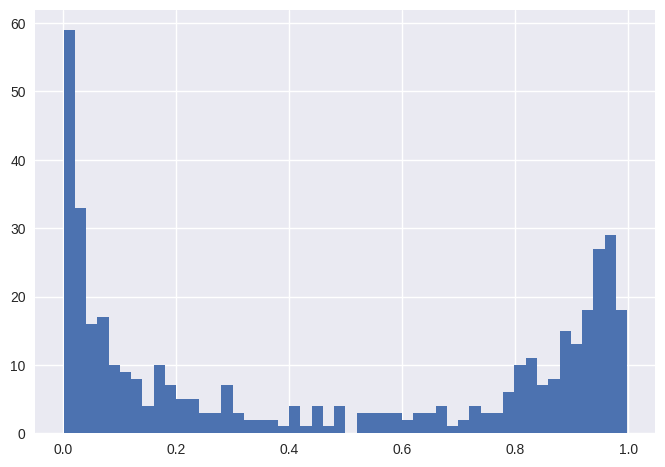

In [ ]:
plt.hist(pred, bins = 50);

In [ ]:
test["proba"] = model.predict(test_s[cols])

14/14 [==============================] - 0s 11ms/step


In [ ]:
test["position"] = np.where(test.proba < 0.47, -1, np.nan) # 1. short where proba < 0.47

In [ ]:
test["position"] = np.where(test.proba > 0.53, 1, test.position) # 2. long where proba > 0.53

In [ ]:
test["position"].min()


-1.0

In [ ]:
test["position"]

Datetime
2024-02-21 09:00:00+00:00   -1.00000
2024-02-21 10:00:00+00:00    1.00000
2024-02-21 11:00:00+00:00    1.00000
2024-02-21 12:00:00+00:00    1.00000
2024-02-21 13:00:00+00:00    1.00000
                              ...   
2024-03-15 18:00:00+00:00   -1.00000
2024-03-15 19:00:00+00:00    1.00000
2024-03-15 20:00:00+00:00   -1.00000
2024-03-15 21:00:00+00:00   -1.00000
2024-03-15 22:00:00+00:00    1.00000
Name: position, Length: 419, dtype: float64

In [ ]:
test.index = test.index.tz_convert('UTC')
test["NYTime"] = test.index.tz_convert("America/New_York")
test["hour"] = test.NYTime.dt.hour

In [ ]:
test["position"] = np.where(~test.hour.between(2, 12), 0, test.position) # 3. neutral in non-busy hours

In [ ]:
test["position"] = test.position.ffill().fillna(0) # 4. in all other cases: hold position

In [ ]:
test.position.value_counts(dropna = False)

0.00000     223
1.00000     104
-1.00000     92
Name: position, dtype: int64

In [ ]:
test["strategy"] = test["position"] * test["returns"]

In [ ]:
test["creturns"] = test["returns"].cumsum().apply(np.exp)
test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)

In [ ]:
test["creturns"].describe()

count   419.00000
mean      1.00573
std       0.00433
min       0.99881
25%       1.00217
50%       1.00423
75%       1.01054
max       1.01392
Name: creturns, dtype: float64

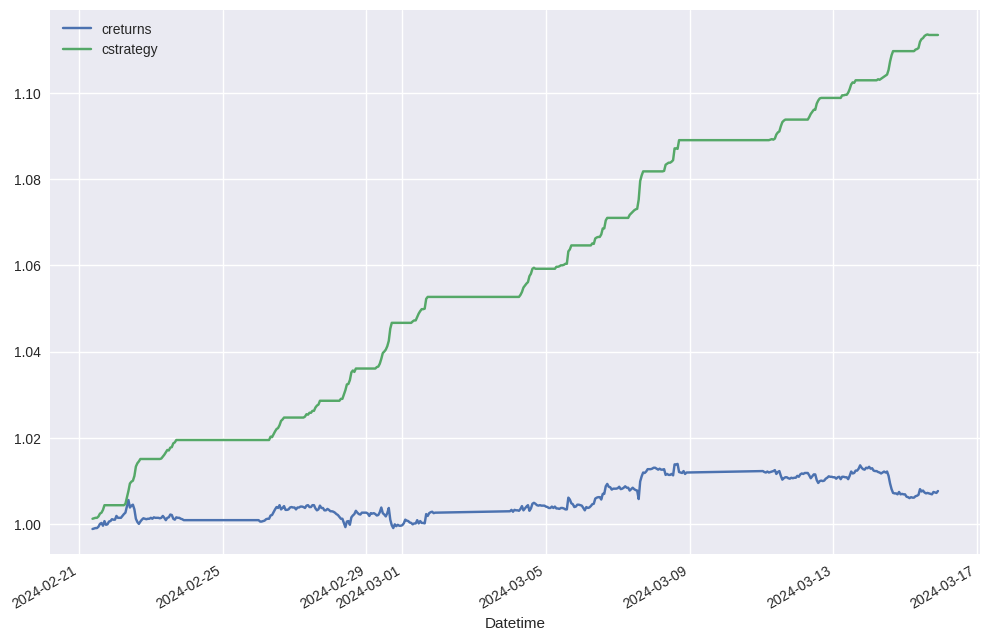

In [ ]:
test[["creturns", "cstrategy"]].plot(figsize = (12, 8))
plt.show()

In [ ]:
ptc = 0.000059

In [ ]:
test["trades"] = test.position.diff().abs()

In [ ]:
test.trades.value_counts()

0.00000    285
2.00000     98
1.00000     35
Name: trades, dtype: int64

In [ ]:
test["strategy_net"] = test.strategy - test.trades * ptc

In [ ]:
test["cstrategy_net"] = test["strategy_net"].cumsum().apply(np.exp)

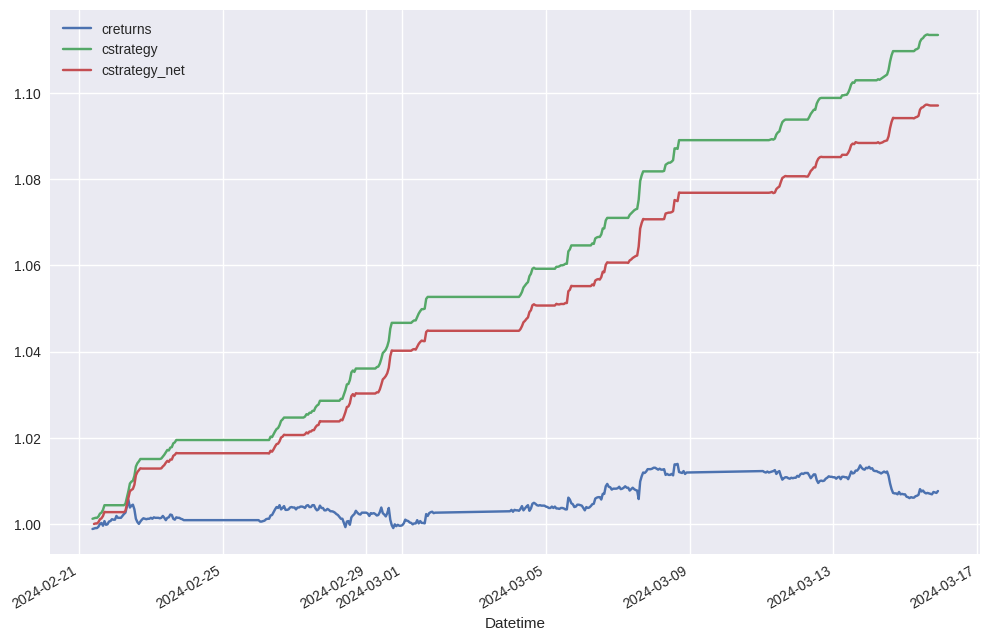

In [ ]:
test[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12, 8))
plt.show()

## Saving Model and Parameters

In [ ]:
model

In [ ]:
mu

Open              1.08494
High              1.08546
Low               1.08442
Close             1.08493
Adj Close         1.08493
returns          -0.00001
Min/Max Points   -0.00123
target           -0.55857
dir               0.46116
sma              -0.00166
boll             -0.03853
min              -0.00291
max               0.00369
mom              -0.00001
vol               0.00077
lag1             -0.00001
lag2             -0.00001
lag3             -0.00001
lag4             -0.00001
lag5             -0.00001
Ask_Dir           0.50062
SMA              -0.00001
SMA_Dir           0.48829
RSI              50.05424
RSI_Dir           0.50308
fastk            50.38259
fastd            50.38456
fastk_Dir         0.47226
fastd_Dir         0.46363
dtype: float64

In [ ]:
std

Open              0.00763
High              0.00767
Low               0.00757
Close             0.00762
Adj Close         0.00762
returns           0.00080
Min/Max Points    0.07856
target            0.82997
dir               0.49880
sma               0.00236
boll              1.27264
min               0.00192
max               0.00329
mom               0.00045
vol               0.00021
lag1              0.00080
lag2              0.00080
lag3              0.00080
lag4              0.00080
lag5              0.00080
Ask_Dir           0.50031
SMA               0.00021
SMA_Dir           0.50017
RSI               4.25725
RSI_Dir           0.50030
fastk            38.43527
fastd            22.18893
fastk_Dir         0.49954
fastd_Dir         0.49898
dtype: float64

In [ ]:
model.save("DNN_model")

2024-03-16 12:33:27.328680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-16 12:33:27.435130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-16 12:33:27.540555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-16 12:33:27

2024-03-16 12:33:30.190392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-16 12:33:30.442404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-16 12:33:30.802024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: DNN_model/assets


In [ ]:
import pickle

In [ ]:
params = {"mu":mu, "std":std}

In [ ]:
params

{'mu': Open              1.08494
 High              1.08546
 Low               1.08442
 Close             1.08493
 Adj Close         1.08493
 returns          -0.00001
 Min/Max Points   -0.00123
 target           -0.55857
 dir               0.46116
 sma              -0.00166
 boll             -0.03853
 min              -0.00291
 max               0.00369
 mom              -0.00001
 vol               0.00077
 lag1             -0.00001
 lag2             -0.00001
 lag3             -0.00001
 lag4             -0.00001
 lag5             -0.00001
 Ask_Dir           0.50062
 SMA              -0.00001
 SMA_Dir           0.48829
 RSI              50.05424
 RSI_Dir           0.50308
 fastk            50.38259
 fastd            50.38456
 fastk_Dir         0.47226
 fastd_Dir         0.46363
 dtype: float64,
 'std': Open              0.00763
 High              0.00767
 Low               0.00757
 Close             0.00762
 Adj Close         0.00762
 returns           0.00080
 Min/Max Points    0.0785

In [ ]:
pickle.dump(params, open("params.pkl", "wb"))

## Implementation

In [ ]:
import pandas as pd
import numpy as np
import tpqoa
import fxcmpy
from datetime import datetime, timedelta
import time

/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/v20-3.0.25.0-py3.8.egg/v20/request.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/v20-3.0.25.0-py3.8.egg/v20/request.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?


__Loading Model and Parameters__

In [ ]:
# Loading the model
import keras
model = keras.models.load_model("DNN_model")

In [ ]:
model

In [ ]:
# Loading mu and std
import pickle
params = pickle.load(open("params.pkl", "rb"))
mu = params["mu"]
std = params["std"]

In [ ]:
mu

Open              1.08494
High              1.08546
Low               1.08442
Close             1.08493
Adj Close         1.08493
returns          -0.00001
Min/Max Points   -0.00123
target           -0.55857
dir               0.46116
sma              -0.00166
boll             -0.03853
min              -0.00291
max               0.00369
mom              -0.00001
vol               0.00077
lag1             -0.00001
lag2             -0.00001
lag3             -0.00001
lag4             -0.00001
lag5             -0.00001
Ask_Dir           0.50062
SMA              -0.00001
SMA_Dir           0.48829
RSI              50.05424
RSI_Dir           0.50308
fastk            50.38259
fastd            50.38456
fastk_Dir         0.47226
fastd_Dir         0.46363
dtype: float64

In [ ]:
std

Open              0.00763
High              0.00767
Low               0.00757
Close             0.00762
Adj Close         0.00762
returns           0.00080
Min/Max Points    0.07856
target            0.82997
dir               0.49880
sma               0.00236
boll              1.27264
min               0.00192
max               0.00329
mom               0.00045
vol               0.00021
lag1              0.00080
lag2              0.00080
lag3              0.00080
lag4              0.00080
lag5              0.00080
Ask_Dir           0.50031
SMA               0.00021
SMA_Dir           0.50017
RSI               4.25725
RSI_Dir           0.50030
fastk            38.43527
fastd            22.18893
fastk_Dir         0.49954
fastd_Dir         0.49898
dtype: float64

__[FXCM] Implementation__

In [ ]:
api = fxcmpy.fxcmpy(config_file= "FXCM.cfg")

OSError: Can not open config file: FXCM.cfg

In [ ]:
col = ["tradeId", "amountK", "currency", "grossPL", "isBuy"]

In [ ]:
class DNNTrader():
    
    def __init__(self, instrument, bar_length, window, lags, model, mu, std, units):
        self.instrument = instrument
        self.bar_length = pd.to_timedelta(bar_length) 
        self.tick_data = None
        self.raw_data = None
        self.data = None 
        self.ticks = 0
        self.last_bar = None  
        self.units = units
        self.position = 0
        
        #*****************add strategy-specific attributes here******************
        self.window = window
        self.lags = lags
        self.model = model
        self.mu = mu
        self.std = std
        #************************************************************************        
    
    def get_most_recent(self, period = "m1", number = 10000):
        while True:  
            time.sleep(5)
            df = api.get_candles(self.instrument, number = number, period = period, columns = ["bidclose", "askclose"])
            df[self.instrument] = (df.bidclose + df.askclose) / 2
            df = df[self.instrument].to_frame()
            df = df.resample(self.bar_length, label = "right").last().dropna().iloc[:-1]
            self.raw_data = df.copy()
            self.last_bar = self.raw_data.index[-1]
            if pd.to_datetime(datetime.utcnow()) - self.last_bar < self.bar_length:
                self.start_time = pd.to_datetime(datetime.utcnow()) # NEW -> Start Time of Trading Session
                break
    
    def get_tick_data(self, data, dataframe):
        
        self.ticks += 1
        print(self.ticks, end = " ", flush = True)
        
        recent_tick = pd.to_datetime(data["Updated"], unit = "ms")
        
        if recent_tick - self.last_bar > self.bar_length:
            self.tick_data = dataframe.loc[self.last_bar:, ["Bid", "Ask"]]
            self.tick_data[self.instrument] = (self.tick_data.Ask + self.tick_data.Bid)/2
            self.tick_data = self.tick_data[self.instrument].to_frame()
            self.resample_and_join()
            self.define_strategy() 
            self.execute_trades()
            
    def resample_and_join(self):
        self.raw_data = self.raw_data.append(self.tick_data.resample(self.bar_length, 
                                                             label="right").last().ffill().iloc[:-1])
        self.last_bar = self.raw_data.index[-1]  
        
    def define_strategy(self): # "strategy-specific"
        df = self.raw_data.copy()
        
        #******************** define your strategy here ************************
        df = df.append(self.tick_data.iloc[-1]) # append latest tick (== open price of current bar)
        df["returns"] = np.log(df[self.instrument] / df[self.instrument].shift())
        df["dir"] = np.where(df["returns"] > 0, 1, 0)
        df["sma"] = df[self.instrument].rolling(self.window).mean() - df[self.instrument].rolling(150).mean()
        df["boll"] = (df[self.instrument] - df[self.instrument].rolling(self.window).mean()) / df[self.instrument].rolling(self.window).std()
        df["min"] = df[self.instrument].rolling(self.window).min() / df[self.instrument] - 1
        df["max"] = df[self.instrument].rolling(self.window).max() / df[self.instrument] - 1
        df["mom"] = df["returns"].rolling(3).mean()
        df["vol"] = df["returns"].rolling(self.window).std()
        df.dropna(inplace = True)
        
        # create lags
        self.cols = []
        features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            df[col] = df["returns"].shift(lag)
            cols.append(col)
                
                
        df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
        cols.append('Ask_Dir')

        df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
        cols.append('SMA')
        df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
        cols.append('SMA_Dir')

        df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
        cols.append('RSI')
        df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
        cols.append('RSI_Dir')

        df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        cols.append('fastk')
        cols.append('fastd')
        df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
        cols.append('fastk_Dir')
        df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)    
        cols.append('fastd_Dir')                
                
        df.dropna(inplace = True)
        
        # standardization
        df_s = (df - self.mu) / self.std
        # predict
        df["proba"] = self.model.predict(df_s[self.cols])
        
        print(df.columns )
        
        #determine positions
        df = df.loc[self.start_time:].copy() # starting with first live_stream bar (removing historical bars)
        df["position"] = np.where(df.proba < 0.47, -1, np.nan)
        df["position"] = np.where(df.proba > 0.53, 1, df.position)
        df["position"] = df.position.ffill().fillna(0) # start with neutral position if no strong signal
        #***********************************************************************
        
        self.data = df.copy()
    
    def execute_trades(self):
        if self.data["position"].iloc[-1] == 1:
            if self.position == 0:
                order = api.create_market_buy_order(self.instrument, self.units)
                self.report_trade(order, "GOING LONG")  
            elif self.position == -1:
                order = api.create_market_buy_order(self.instrument, self.units * 2)
                self.report_trade(order, "GOING LONG")  
            self.position = 1
        elif self.data["position"].iloc[-1] == -1: 
            if self.position == 0:
                order = api.create_market_sell_order(self.instrument, self.units)
                self.report_trade(order, "GOING SHORT")  
            elif self.position == 1:
                order = api.create_market_sell_order(self.instrument, self.units * 2)
                self.report_trade(order, "GOING SHORT")  
            self.position = -1
        elif self.data["position"].iloc[-1] == 0: 
            if self.position == -1:
                order = api.create_market_buy_order(self.instrument, self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            elif self.position == 1:
                order = api.create_market_sell_order(self.instrument, self.units)
                self.report_trade(order, "GOING NEUTRAL")  
            self.position = 0

    def report_trade(self, order, going):
        time = order.get_time()
        units = api.get_open_positions().amountK.iloc[-1]
        price = api.get_open_positions().open.iloc[-1]
        unreal_pl = api.get_open_positions().grossPL.sum()
        print("\n" + 100* "-")
        print("{} | {}".format(time, going))
        print("{} | units = {} | price = {} | Unreal. P&L = {}".format(time, units, price, unreal_pl))
        print(100 * "-" + "\n")

In [ ]:
trader = DNNTrader("EUR/USD", bar_length = "20min", 
                   window = 50, lags = 5, model = model, mu = mu, std = std, units = 100)

In [ ]:

trader.get_most_recent()
api.subscribe_market_data(trader.instrument, (trader.get_tick_data, ))

In [ ]:
'''
api.unsubscribe_market_data(trader.instrument)
if len(api.get_open_positions()) != 0: # if we have final open position(s) (netting and hedging)
    api.close_all_for_symbol(trader.instrument)
    print(2*"\n" + "{} | GOING NEUTRAL".format(str(datetime.utcnow())) + "\n")
    time.sleep(20)
    print(api.get_closed_positions_summary()[col])
    trader.position = 0
'''

'\napi.unsubscribe_market_data(trader.instrument)\nif len(api.get_open_positions()) != 0: # if we have final open position(s) (netting and hedging)\n    api.close_all_for_symbol(trader.instrument)\n    print(2*"\n" + "{} | GOING NEUTRAL".format(str(datetime.utcnow())) + "\n")\n    time.sleep(20)\n    print(api.get_closed_positions_summary()[col])\n    trader.position = 0\n'

In [ ]:
#trader.data

In [ ]:
#api.close()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 